## Importing stuff

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split, DataLoader, TensorDataset

import numpy as np
import math
import datetime 

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.colors import BoundaryNorm
from matplotlib.colors import LogNorm

import iris
import iris.plot as iplt
import iris.coord_categorisation

from FLO_utils import extract_cube_area, add_bounds, __callback_add_forecast_day
from RH_wrt_water import RH_wrt_water_from_cubes

## Define some local functions

In [2]:
def calc_cube_daymean(cube):
    cube_daymean = cube.copy()
    aux_coord_names = [coord.name() for coord in cube.aux_coords]

    if "year" not in aux_coord_names:
        iris.coord_categorisation.add_year(cube, 'time')
        
    if "day_of_year" not in aux_coord_names:   
        iris.coord_categorisation.add_day_of_year(cube, 'time')
        
    cube_daymean = cube.aggregated_by(['year', 'day_of_year'], iris.analysis.MEAN)
    
    return cube_daymean

## Loading Data

In [3]:
AQUM_PATH = "/scratch/fmalavel/mass_retrievals/u-df278/"
AQUM_files = ["*202205*.pp"]
AQUM_filelist = [AQUM_PATH + x for x in AQUM_files]
print(f"\n{AQUM_filelist}")

all_cubes = iris.load(AQUM_filelist, None, __callback_add_forecast_day )#, time_constraint)
print(f"\n{all_cubes}")

# time constraint
start_datetime=datetime.datetime(2022,5,1,0)
end_datetime=datetime.datetime(2022,5,12,0)

time_constraint = iris.Constraint(
    time=lambda c: c.point >= start_datetime
    and c.point <= end_datetime)

# Thermodynamics Constraints
t_con = iris.AttributeConstraint(STASH='m01s00i004')
q_con = iris.AttributeConstraint(STASH='m01s00i010')
p_con = iris.AttributeConstraint(STASH='m01s00i408')

# PM Constraints
pm10wet_con = iris.AttributeConstraint(STASH='m01s38i560')
pm2p5wet_con = iris.AttributeConstraint(STASH='m01s38i561')
pm10dry_con = iris.AttributeConstraint(STASH='m01s38i562')
pm2p5dry_con = iris.AttributeConstraint(STASH='m01s38i563')

# GLOMAP MMR Constraints
ait_ins_bc_con = iris.AttributeConstraint(STASH='m01s34i120')
ait_ins_om_con = iris.AttributeConstraint(STASH='m01s34i121')
ait_sol_so4_con = iris.AttributeConstraint(STASH='m01s34i104')
ait_sol_bc_con = iris.AttributeConstraint(STASH='m01s34i105')
ait_sol_om_con = iris.AttributeConstraint(STASH='m01s34i106')
ait_sol_no3_con = iris.AttributeConstraint(STASH='m01s34i137')
ait_sol_nh4_con = iris.AttributeConstraint(STASH='m01s34i133')
acc_sol_so4_con = iris.AttributeConstraint(STASH='m01s34i108')
acc_sol_bc_con = iris.AttributeConstraint(STASH='m01s34i109')
acc_sol_om_con = iris.AttributeConstraint(STASH='m01s34i110')
acc_sol_ss_con = iris.AttributeConstraint(STASH='m01s34i111')
acc_sol_no3_con = iris.AttributeConstraint(STASH='m01s34i138')
acc_sol_nh4_con = iris.AttributeConstraint(STASH='m01s34i134')
coa_sol_so4_con = iris.AttributeConstraint(STASH='m01s34i114')
coa_sol_bc_con = iris.AttributeConstraint(STASH='m01s34i115')
coa_sol_om_con = iris.AttributeConstraint(STASH='m01s34i116')
coa_sol_ss_con = iris.AttributeConstraint(STASH='m01s34i117')
coa_sol_no3_con = iris.AttributeConstraint(STASH='m01s34i139')
coa_sol_nh4_con = iris.AttributeConstraint(STASH='m01s34i135')

# GLOMAP Number Constraints
ait_sol_number_con = iris.AttributeConstraint(STASH='m01s34i103')
acc_sol_number_con = iris.AttributeConstraint(STASH='m01s34i107')
coa_sol_number_con = iris.AttributeConstraint(STASH='m01s34i113')
ait_ins_number_con = iris.AttributeConstraint(STASH='m01s34i119')

# Time constratints
fcst_day_cons = iris.Constraint(forecast_day=1)

# Loading Specific cubes ...

# Thermodynamics
theta = all_cubes.extract_cube(t_con & fcst_day_cons & time_constraint)
p =  all_cubes.extract_cube(p_con & fcst_day_cons & time_constraint)
q = all_cubes.extract_cube(q_con & fcst_day_cons & time_constraint)

# PM
pm10wet = all_cubes.extract_cube(pm10wet_con & fcst_day_cons & time_constraint)
pm10dry = all_cubes.extract_cube(pm10dry_con & fcst_day_cons & time_constraint)
pm2p5wet = all_cubes.extract_cube(pm2p5wet_con & fcst_day_cons & time_constraint)
pm2p5dry = all_cubes.extract_cube(pm2p5dry_con & fcst_day_cons & time_constraint)

# Mode MMRs
ait_ins_bc = all_cubes.extract_cube(ait_ins_bc_con & fcst_day_cons & time_constraint)
ait_ins_om = all_cubes.extract_cube(ait_ins_om_con & fcst_day_cons & time_constraint)
ait_sol_so4 = all_cubes.extract_cube(ait_sol_so4_con & fcst_day_cons & time_constraint)
ait_sol_bc = all_cubes.extract_cube(ait_sol_bc_con & fcst_day_cons & time_constraint)
ait_sol_om = all_cubes.extract_cube(ait_sol_om_con & fcst_day_cons & time_constraint)
ait_sol_no3 = all_cubes.extract_cube(ait_sol_no3_con & fcst_day_cons & time_constraint)
ait_sol_nh4 = all_cubes.extract_cube(ait_sol_nh4_con & fcst_day_cons & time_constraint)
acc_sol_so4 = all_cubes.extract_cube(acc_sol_so4_con & fcst_day_cons & time_constraint)
acc_sol_bc = all_cubes.extract_cube(acc_sol_bc_con & fcst_day_cons & time_constraint)
acc_sol_om = all_cubes.extract_cube(acc_sol_om_con & fcst_day_cons & time_constraint)
acc_sol_ss = all_cubes.extract_cube(acc_sol_ss_con & fcst_day_cons & time_constraint)
acc_sol_no3 = all_cubes.extract_cube(acc_sol_no3_con & fcst_day_cons & time_constraint)
acc_sol_nh4 = all_cubes.extract_cube(acc_sol_nh4_con & fcst_day_cons & time_constraint)
coa_sol_so4 = all_cubes.extract_cube(coa_sol_so4_con & fcst_day_cons & time_constraint)
coa_sol_bc = all_cubes.extract_cube(coa_sol_bc_con & fcst_day_cons & time_constraint)
coa_sol_om = all_cubes.extract_cube(coa_sol_om_con & fcst_day_cons & time_constraint)
coa_sol_ss = all_cubes.extract_cube(coa_sol_ss_con & fcst_day_cons & time_constraint)
coa_sol_no3 = all_cubes.extract_cube(coa_sol_no3_con & fcst_day_cons & time_constraint)
coa_sol_nh4 = all_cubes.extract_cube(coa_sol_nh4_con & fcst_day_cons & time_constraint)

# Mode Numbers
ait_sol_number = all_cubes.extract_cube(ait_sol_number_con & fcst_day_cons & time_constraint)
acc_sol_number = all_cubes.extract_cube(acc_sol_number_con & fcst_day_cons & time_constraint)
coa_sol_number = all_cubes.extract_cube(coa_sol_number_con & fcst_day_cons & time_constraint)
ait_ins_number = all_cubes.extract_cube(ait_ins_number_con & fcst_day_cons & time_constraint)

print(f"\n{pm2p5dry}")


['/scratch/fmalavel/mass_retrievals/u-df278/*202205*.pp']


/data/users/fmalavel/.conda/envs/eumetnet/lib/python3.8/site-packages/iris/fileformats/rules.py:353: UserWarning: Unable to create instance of HybridHeightFactory. The source data contains no field(s) for 'orography'.
  warnings.warn(msg.format(factory=factory_name))



0: number_of_particles_per_air_molecule_of_soluble_aitken_mode_aerosol_in_air / (1) (time: 744; grid_latitude: 182; grid_longitude: 146)
1: mass_fraction_of_sulfuric_acid_in_soluble_aitken_mode_dry_aerosol_in_air / (kg kg-1) (time: 744; grid_latitude: 182; grid_longitude: 146)
2: mass_fraction_of_black_carbon_in_soluble_aitken_mode_dry_aerosol_in_air / (kg kg-1) (time: 744; grid_latitude: 182; grid_longitude: 146)
3: mass_fraction_of_particulate_organic_matter_in_soluble_aitken_mode_dry_aerosol_in_air / (kg kg-1) (time: 744; grid_latitude: 182; grid_longitude: 146)
4: number_of_particles_per_air_molecule_of_soluble_accumulation_mode_aerosol_in_air / (1) (time: 744; grid_latitude: 182; grid_longitude: 146)
5: mass_fraction_of_sulfuric_acid_in_soluble_accumulation_mode_dry_aerosol_in_air / (kg kg-1) (time: 744; grid_latitude: 182; grid_longitude: 146)
6: mass_fraction_of_black_carbon_in_soluble_accumulation_mode_dry_aerosol_in_air / (kg kg-1) (time: 744; grid_latitude: 182; grid_longitu

In [4]:
print(pm2p5dry.coord("time"))

DimCoord :  time / (hours since 1970-01-01 00:00:00, standard calendar)
    points: [
        2022-05-02 01:30:00, 2022-05-02 02:30:00, ...,
        2022-05-11 22:30:00, 2022-05-11 23:30:00]
    bounds: [
        [2022-05-02 01:00:00, 2022-05-02 02:00:00],
        [2022-05-02 02:00:00, 2022-05-02 03:00:00],
        ...,
        [2022-05-11 22:00:00, 2022-05-11 23:00:00],
        [2022-05-11 23:00:00, 2022-05-12 00:00:00]]
    shape: (230,)  bounds(230, 2)
    dtype: float64
    standard_name: 'time'


## Process cubes

In [5]:
# Calculate rh
rhw = RH_wrt_water_from_cubes(theta=theta, p=p, q=q)

# Combine Mode MMRs into one cube
modes_ait = (pm2p5dry).copy()
modes_acc = (pm2p5dry).copy()
modes_coa = (pm2p5dry).copy()
modes_all = (pm2p5dry).copy()

modes_ait.data = modes_ait.data * 0.0
modes_acc.data = modes_acc.data * 0.0
modes_coa.data = modes_coa.data * 0.0
modes_all.data = modes_all.data * 0.0

rho_air = 1.25  # assumes pho_air is 1.25 kg/m3
kgkg_to_ugm3 = rho_air * 1e9     # convert mmr (kg/kg) to concentration (ug/m3)
g_to_kg = 1e-3
m3_to_cm3 = 1e6

modes_ait.data = \
        (ait_ins_bc.data + ait_ins_om.data + \
        ait_sol_so4.data + ait_sol_bc.data + \
        ait_sol_om.data + ait_sol_no3.data + \
        ait_sol_nh4.data) * kgkg_to_ugm3

modes_acc.data = \
        (acc_sol_so4.data + acc_sol_bc.data + \
        acc_sol_om.data + acc_sol_ss.data + \
        acc_sol_no3.data + acc_sol_nh4.data) * kgkg_to_ugm3

modes_coa.data = \
        (coa_sol_so4.data + coa_sol_bc.data + \
        coa_sol_om.data + coa_sol_ss.data + \
        coa_sol_no3.data + coa_sol_nh4.data) * kgkg_to_ugm3

modes_all.data = \
        (ait_ins_bc.data + ait_ins_om.data + \
        ait_sol_so4.data + ait_sol_bc.data + \
        ait_sol_om.data + ait_sol_no3.data + \
        ait_sol_nh4.data + \
        acc_sol_so4.data + acc_sol_bc.data + \
        acc_sol_om.data + acc_sol_ss.data + \
        acc_sol_no3.data + acc_sol_nh4.data + \
        coa_sol_so4.data + coa_sol_bc.data + \
        coa_sol_om.data + coa_sol_ss.data + \
        coa_sol_no3.data + coa_sol_nh4.data) * kgkg_to_ugm3

modes_ait.units = "ug.m-3"
modes_acc.units = "ug.m-3"
modes_coa.units = "ug.m-3"
modes_all.units = "ug.m-3"


# Convert the NMR expressed as (mol/mol) to number/cm3 
boltzmann       = 1.380649e-23
aird = 1013e2 / 282 / boltzmann

#ait_sol_number.data = ait_sol_number.data * aird / m3_to_cm3
#acc_sol_number.data = acc_sol_number.data * aird / m3_to_cm3
#coa_sol_number.data = coa_sol_number.data * aird / m3_to_cm3
#ait_ins_number.data = ait_ins_number.data * aird / m3_to_cm3
#ait_sol_number.units = "mol/mol"
#acc_sol_number.units = "mol/mol"
#coa_sol_number.units = "mol/mol"
#ait_ins_number.units = "mol/mol"

#add bounds and remove domain edges
add_bounds(rhw)
add_bounds(modes_ait)
add_bounds(modes_acc)
add_bounds(modes_coa)
add_bounds(modes_all)
add_bounds(pm10wet)
add_bounds(pm10dry)
add_bounds(pm2p5wet)
add_bounds(pm2p5dry)
add_bounds(ait_sol_number)
add_bounds(acc_sol_number)
add_bounds(coa_sol_number)
add_bounds(ait_ins_number)

domain_dict = {
    "MINLON":-8.5,
    "MAXLON":5.25,
    "MINLAT":48.75,
    "MAXLAT":60.5,
}

extract_rhw = extract_cube_area(calc_cube_daymean(rhw),
                                MINLON=domain_dict["MINLON"],
                                MAXLON=domain_dict["MAXLON"],
                                MINLAT=domain_dict["MINLAT"],
                                MAXLAT=domain_dict["MAXLAT"],
                               )
extract_pm2p5dry = extract_cube_area(calc_cube_daymean(pm2p5dry),
                                     MINLON=domain_dict["MINLON"],
                                     MAXLON=domain_dict["MAXLON"],
                                     MINLAT=domain_dict["MINLAT"],
                                     MAXLAT=domain_dict["MAXLAT"],
                                    )
extract_pm2p5wet = extract_cube_area(calc_cube_daymean(pm2p5wet),
                                     MINLON=domain_dict["MINLON"],
                                     MAXLON=domain_dict["MAXLON"],
                                     MINLAT=domain_dict["MINLAT"],
                                     MAXLAT=domain_dict["MAXLAT"],
                                    )
extract_pm10dry = extract_cube_area(calc_cube_daymean(pm10dry),
                                     MINLON=domain_dict["MINLON"],
                                     MAXLON=domain_dict["MAXLON"],
                                     MINLAT=domain_dict["MINLAT"],
                                     MAXLAT=domain_dict["MAXLAT"],
                                    )
extract_pm10wet = extract_cube_area(calc_cube_daymean(pm10wet),
                                    MINLON=domain_dict["MINLON"],
                                    MAXLON=domain_dict["MAXLON"],
                                    MINLAT=domain_dict["MINLAT"],
                                    MAXLAT=domain_dict["MAXLAT"],
                                   )
extract_modes_ait = extract_cube_area(calc_cube_daymean(modes_ait),
                                      MINLON=domain_dict["MINLON"],
                                      MAXLON=domain_dict["MAXLON"],
                                      MINLAT=domain_dict["MINLAT"],
                                      MAXLAT=domain_dict["MAXLAT"],
                                     )
extract_modes_acc = extract_cube_area(calc_cube_daymean(modes_acc),
                                      MINLON=domain_dict["MINLON"],
                                      MAXLON=domain_dict["MAXLON"],
                                      MINLAT=domain_dict["MINLAT"],
                                      MAXLAT=domain_dict["MAXLAT"],
                                     )
extract_modes_coa = extract_cube_area(calc_cube_daymean(modes_coa),
                                      MINLON=domain_dict["MINLON"],
                                      MAXLON=domain_dict["MAXLON"],
                                      MINLAT=domain_dict["MINLAT"],
                                      MAXLAT=domain_dict["MAXLAT"],
                                     )
extract_modes_all = extract_cube_area(calc_cube_daymean(modes_all),
                                      MINLON=domain_dict["MINLON"],
                                      MAXLON=domain_dict["MAXLON"],
                                      MINLAT=domain_dict["MINLAT"],
                                      MAXLAT=domain_dict["MAXLAT"],
                                     )
extract_ait_sol_number = extract_cube_area(calc_cube_daymean(ait_sol_number),
                                      MINLON=domain_dict["MINLON"],
                                      MAXLON=domain_dict["MAXLON"],
                                      MINLAT=domain_dict["MINLAT"],
                                      MAXLAT=domain_dict["MAXLAT"],
                                     )
extract_acc_sol_number = extract_cube_area(calc_cube_daymean(acc_sol_number),
                                      MINLON=domain_dict["MINLON"],
                                      MAXLON=domain_dict["MAXLON"],
                                      MINLAT=domain_dict["MINLAT"],
                                      MAXLAT=domain_dict["MAXLAT"],
                                     )
extract_coa_sol_number = extract_cube_area(calc_cube_daymean(coa_sol_number),
                                      MINLON=domain_dict["MINLON"],
                                      MAXLON=domain_dict["MAXLON"],
                                      MINLAT=domain_dict["MINLAT"],
                                      MAXLAT=domain_dict["MAXLAT"],
                                     )
extract_ait_ins_number = extract_cube_area(calc_cube_daymean(ait_ins_number),
                                      MINLON=domain_dict["MINLON"],
                                      MAXLON=domain_dict["MAXLON"],
                                      MINLAT=domain_dict["MINLAT"],
                                      MAXLAT=domain_dict["MAXLAT"],
                                     )

print(f"\n{extract_pm2p5dry}")


Reg Lat [48.75 60.5 ] converted to rotated lat coord: [-3.5854782   8.20651527]
Reg Lon [-8.5   5.25] converted to rotated lon coord: [356.04025571 363.84690841]

Reg Lat [48.75 60.5 ] converted to rotated lat coord: [-3.5854782   8.20651527]
Reg Lon [-8.5   5.25] converted to rotated lon coord: [356.04025571 363.84690841]

Reg Lat [48.75 60.5 ] converted to rotated lat coord: [-3.5854782   8.20651527]
Reg Lon [-8.5   5.25] converted to rotated lon coord: [356.04025571 363.84690841]

Reg Lat [48.75 60.5 ] converted to rotated lat coord: [-3.5854782   8.20651527]
Reg Lon [-8.5   5.25] converted to rotated lon coord: [356.04025571 363.84690841]

Reg Lat [48.75 60.5 ] converted to rotated lat coord: [-3.5854782   8.20651527]
Reg Lon [-8.5   5.25] converted to rotated lon coord: [356.04025571 363.84690841]

Reg Lat [48.75 60.5 ] converted to rotated lat coord: [-3.5854782   8.20651527]
Reg Lon [-8.5   5.25] converted to rotated lon coord: [356.04025571 363.84690841]

Reg Lat [48.75 60.5 ]

In [17]:
print(extract_pm2p5dry.coord("time"))

mean_ait_ins = np.mean(extract_ait_ins_number.data)
print(mean_ait_ins)
mean_ait_sol = np.mean(extract_ait_sol_number.data)
print(mean_ait_sol)
mean_acc_sol = np.mean(extract_acc_sol_number.data)
print(mean_acc_sol)

mean_modes_ait = np.mean(extract_modes_ait.data)
print(mean_modes_ait)
mean_modes_acc = np.mean(extract_modes_acc.data)
print(mean_modes_acc)
mean_modes_all = np.mean(extract_modes_all.data)
print(mean_modes_all)

DimCoord :  time / (hours since 1970-01-01 00:00:00, standard calendar)
    points: [
        2022-05-02 12:30:00, 2022-05-03 12:30:00, 2022-05-04 12:30:00,
        2022-05-05 12:30:00, 2022-05-06 12:30:00, 2022-05-07 12:30:00,
        2022-05-08 12:30:00, 2022-05-09 12:30:00, 2022-05-10 12:30:00,
        2022-05-11 12:30:00]
    bounds: [
        [2022-05-02 01:00:00, 2022-05-03 00:00:00],
        [2022-05-03 01:00:00, 2022-05-04 00:00:00],
        ...,
        [2022-05-10 01:00:00, 2022-05-11 00:00:00],
        [2022-05-11 01:00:00, 2022-05-12 00:00:00]]
    shape: (10,)  bounds(10, 2)
    dtype: float64
    standard_name: 'time'
4.363001e-17
7.8776786e-18
1.2739564e-17
1.1379105
4.47703
15.089818


## Initiate NN model

In [7]:
# Define the model
class PM_Net(nn.Module):
    def __init__(self):
        super(PM_Net, self).__init__()
        #self.fc1 = nn.Linear(7, 100)
        self.fc1 = nn.Linear(7, 50)
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialise model
model = PM_Net()

# Loading the model
model.load_state_dict(torch.load("PM2p5_model.NN"))#, weights_only=True))
model.eval()



PM_Net(
  (fc1): Linear(in_features=7, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=1, bias=True)
)

## Loading Trained PM Model

In [8]:
NN_pm2p5dry = extract_pm2p5dry.copy()
#NN_pm2p5wet = extract_pm2p5wet.copy()
#NN_pm10dry = extract_pm10dry.copy()
#NN_pm10wet = extract_pm10wet.copy()

dt, dx, dy = NN_pm2p5dry.data.shape
print(f"{NN_pm2p5dry.data.shape}")

for i in range(dt):
    for j in range(dx):
        for k in range(dy):
            # Define the features/predictors to be used:
            x1_1D = extract_modes_ait.data[i,j,k].reshape(-1, 1)
            x2_1D = extract_modes_acc.data[i,j,k].reshape(-1, 1)
            x3_1D = extract_modes_coa.data[i,j,k].reshape(-1, 1)
            #x4_1D = extract_rhw.data[i,j,k].reshape(-1, 1)
            x5_1D = extract_ait_ins_number.data[i,j,k].reshape(-1, 1)
            x6_1D = extract_coa_sol_number.data[i,j,k].reshape(-1, 1)
            x7_1D = extract_acc_sol_number.data[i,j,k].reshape(-1, 1)
            x8_1D = extract_ait_sol_number.data[i,j,k].reshape(-1, 1)
            x_1D = np.hstack((x1_1D, x2_1D, x3_1D, x5_1D, x6_1D, x7_1D, x8_1D))
            x_array = torch.tensor(x_1D, dtype=torch.float32).unsqueeze(1)
            #print(f"x_array = {x_array}")
            
            with torch.no_grad():
                NN_pm2p5dry.data[i,j,k] = model(x_array).detach().numpy()
                #NN_pm2p5wet.data[i,j,k] = model(x_array).detach().numpy()
                #NN_pm10dry.data[i,j,k] = model(x_array).detach().numpy()
                #NN_pm10wet.data[i,j,k] = model(x_array).detach().numpy()
                #print(f"{NN_pm2p5dry.data[i,j,k]} / {extract_pm2p5dry.data[i,j,k]}")

(10, 106, 70)


## Plot AQUM PM diag vs NN estimates

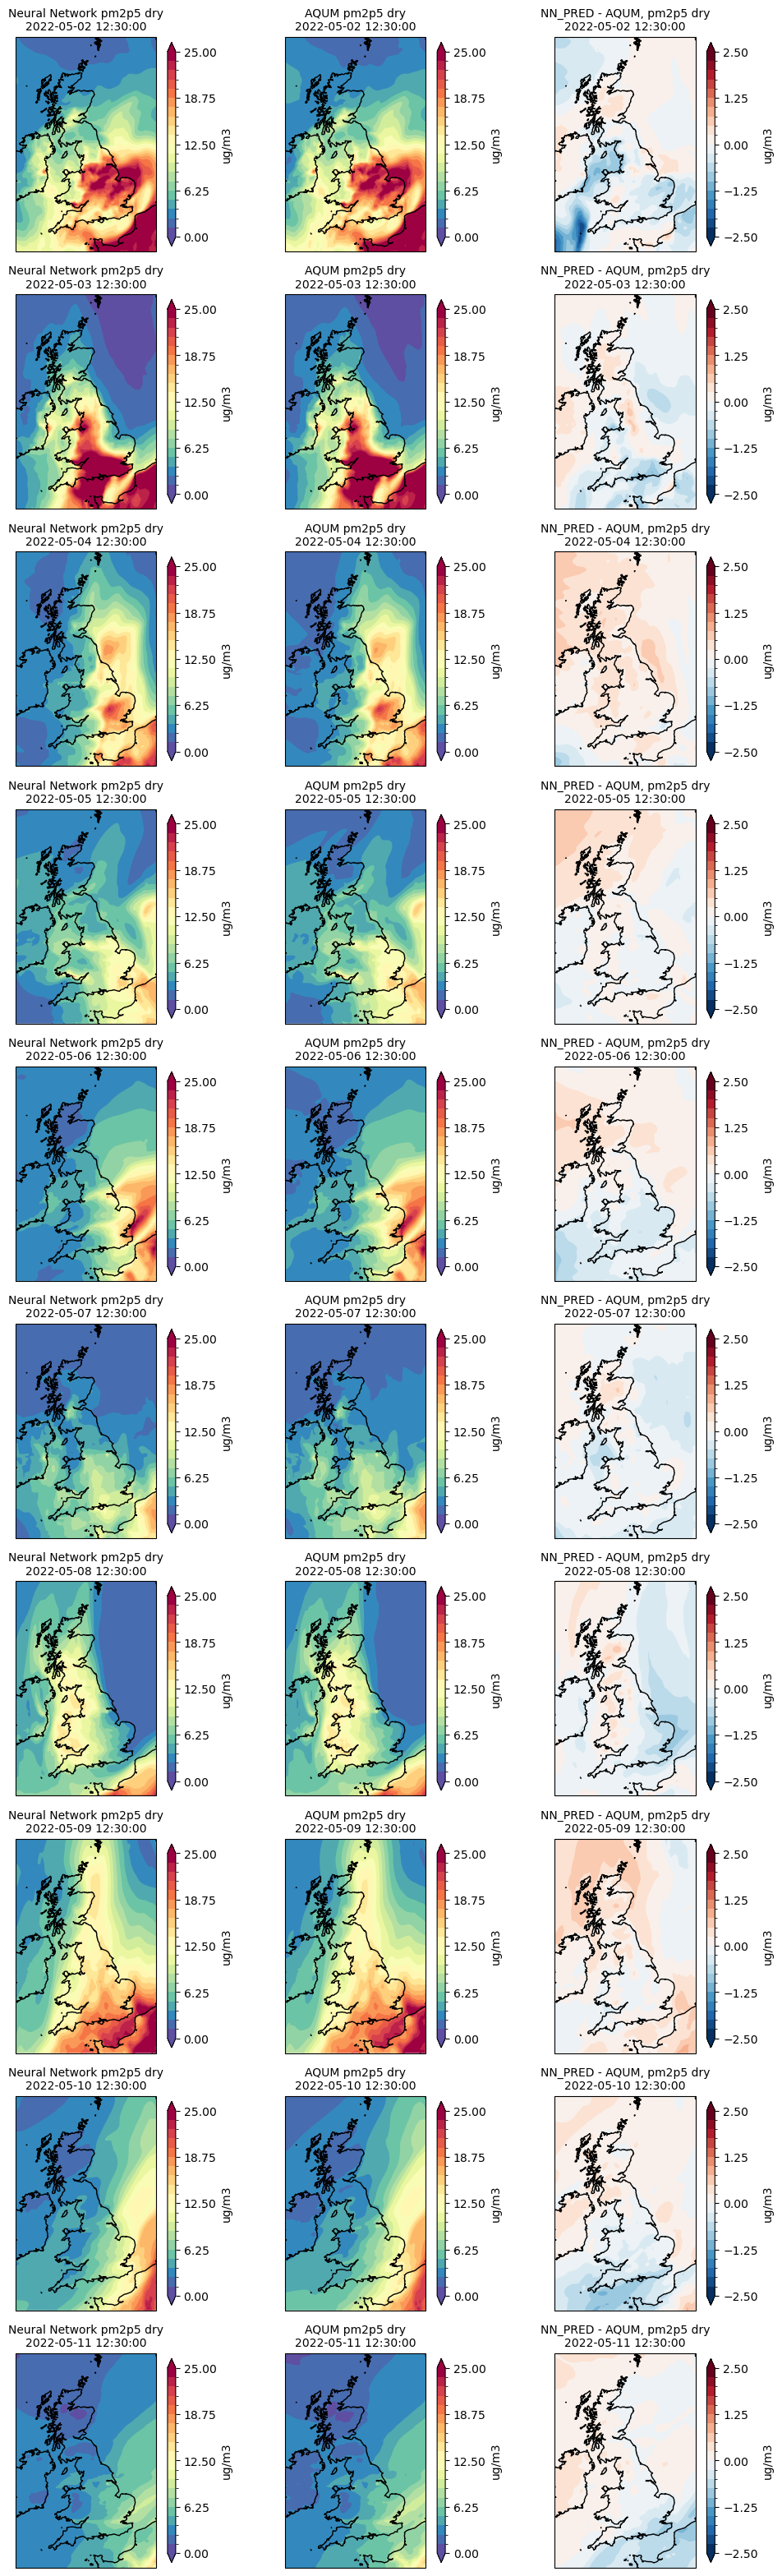

In [9]:
time_coord = extract_pm2p5dry.coord("time")
nt = len(time_coord.points)

fig = plt.figure(figsize=(12,nt*4), dpi=100)

pad = 0.05
sh = 0.95
asp = 25

for n in range(nt):
    string_time = time_coord.units.num2date(time_coord.points[n])
    #print(f"{string_time}")
    
    time_constraint = iris.Constraint(time=lambda t: t.point == time_coord.units.num2date(time_coord.points[n]))
    AQUM_cube = extract_pm2p5dry.extract(time_constraint)
    NN_cube = NN_pm2p5dry.extract(time_constraint)

    
    # PM Neural Network
    #   Fig 1   #
    plt.subplot(nt, 3, n*3+1)
     
    cmap = plt.get_cmap("Spectral")
    cmap_r = cmap.reversed()
    cmap = cmap_r
    
    cb_min=0
    cb_max=25
    
    levels = np.linspace(cb_min, cb_max, 21)
    norm = BoundaryNorm(levels, ncolors=cmap.N, clip=False)
    tick_lvl = levels[0::5]
    cb_label_str = 'ug/m3'
    
    iplt.contourf(NN_cube,
                  levels=levels,
                  cmap=cmap, 
                  norm=norm,
                  extend='both')
    
    plt.colorbar(orientation='vertical',
                 ticks=tick_lvl,
                 # format="%.1e",
                 pad=pad,
                 aspect=asp,
                 shrink=sh).set_label(cb_label_str)
    
    plt.gca().coastlines(resolution='10m')
    plt.title("Neural Network pm2p5 dry" + f"\n{string_time}", fontsize=10, linespacing=1.2)

    # PM MODEL DIAG
    #   Fig 2   #
    plt.subplot(nt, 3, n*3+2)
        
    cmap = plt.get_cmap("Spectral")
    cmap_r = cmap.reversed()
    cmap = cmap_r
    
    cb_min=0
    cb_max=25
    
    levels = np.linspace(cb_min, cb_max, 21)
    norm = BoundaryNorm(levels, ncolors=cmap.N, clip=False)
    tick_lvl = levels[0::5]
    cb_label_str = 'ug/m3'
    
    iplt.contourf(AQUM_cube,
                  levels=levels,
                  cmap=cmap, 
                  norm=norm,
                  extend='both')
    
    plt.colorbar(orientation='vertical',
                 ticks=tick_lvl,
                 # format="%.1e",
                 pad=pad,
                 aspect=asp,
                 shrink=sh).set_label(cb_label_str)
    
    plt.gca().coastlines(resolution='10m')
    plt.title("AQUM pm2p5 dry" + f"\n{string_time}", fontsize=10, linespacing=1.2)


    # PM DIFF: PRED - MODEL DIAG
    #   Fig 3   #
    plt.subplot(nt, 3, n*3+3)

    cmap = plt.get_cmap("RdBu_r")

    cb_min=-2.5
    cb_max=2.5
    levels = np.linspace(cb_min, cb_max, 21)
    norm = BoundaryNorm(levels, ncolors=cmap.N, clip=False)
    tick_lvl = levels[0::5]
    cb_label_str = 'ug/m3'

    Diff = NN_cube - AQUM_cube
    iplt.contourf(Diff,
                  levels=levels,
                  cmap=cmap, 
                  norm=norm,
                  extend='both')

    plt.colorbar(orientation='vertical',
                 ticks=tick_lvl,
                 # format="%.1e",
                 pad=pad,
                 aspect=asp,
                 shrink=sh).set_label(cb_label_str)

    plt.gca().coastlines(resolution='10m')
    plt.title("NN_PRED - AQUM, pm2p5 dry" + f"\n{string_time}", fontsize=10, linespacing=1.2)


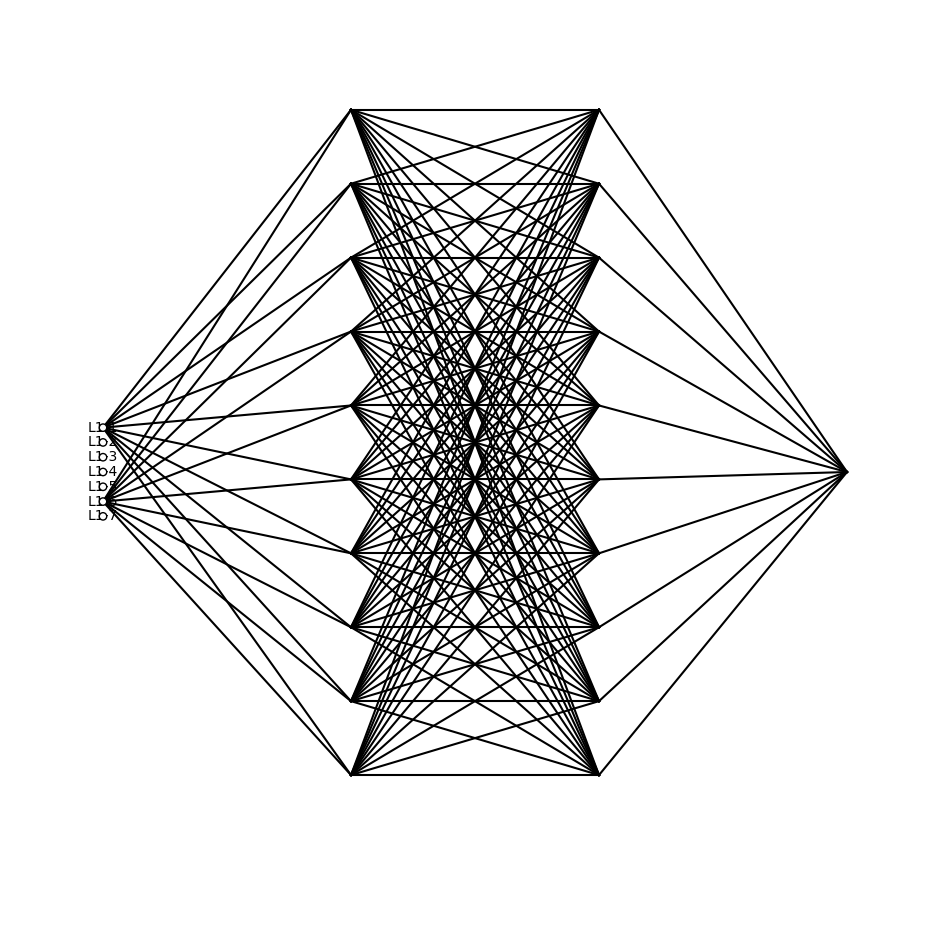

In [23]:
def draw_neural_net(ax, left, right, bottom, top, layer_sizes, draw_every=5):
    '''
    Draw a neural network cartoon using matplotilb.

    :param ax: matplotlib.axes.Axes, the axes on which to plot the cartoon (get e.g. by plt.gca())
    :param left: float, the center of the leftmost node(s) will be placed here
    :param right: float, the center of the rightmost node(s) will be placed here
    :param bottom: float, the center of the bottommost node(s) will be placed here
    :param top: float, the center of the topmost node(s) will be placed here
    :param layer_sizes: list of int, list containing the number of nodes in each layer
    :param draw_every: int, parameter to draw fewer connections by skipping some nodes
    '''
    v_spacing = (top - bottom) / float(max(layer_sizes))
    h_spacing = (right - left) / float(len(layer_sizes) - 1)

    # Nodes
    for n, layer_size in enumerate(layer_sizes):
        layer_top = v_spacing * (layer_size - 1) / 2. + (top + bottom) / 2.
        for m in range(layer_size):
            circle = plt.Circle((n * h_spacing + left, layer_top - m * v_spacing), v_spacing / 4.,
                                color='w', ec='k', zorder=4)
            if (n % 10 == 0 ):
                ax.add_artist(circle)
                # Annotate the nodes
                ax.text(n * h_spacing + left, layer_top - m * v_spacing, f'L{n+1}-{m+1}', color='black', ha='center', va='center')

    # Edges
    for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer_top_a = v_spacing * (layer_size_a - 1) / 2. + (top + bottom) / 2.
        layer_top_b = v_spacing * (layer_size_b - 1) / 2. + (top + bottom) / 2.
        for m in range(0, layer_size_a, draw_every):
            for o in range(0, layer_size_b, draw_every):
                line = plt.Line2D([n * h_spacing + left, (n + 1) * h_spacing + left],
                                  [layer_top_a - m * v_spacing, layer_top_b - o * v_spacing], c='k')
                ax.add_artist(line)

fig = plt.figure(figsize=(12, 12))
ax = fig.gca()
ax.axis('off')

# Define the neural network architecture
layer_sizes = [7, 50, 50, 1]
draw_neural_net(ax, .1, .9, .1, .9, layer_sizes, draw_every=5)
plt.show()